# EPAM DS course. Regression 1.2

# Loading the needed libraries.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
seq_col_brew = sns.color_palette("RdBu_r", 12)
sns.set_palette(seq_col_brew)

from tqdm import tqdm_notebook

import os

import warnings
warnings.filterwarnings('ignore')

from pandas_profiling import ProfileReport

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

random_state=17

from scipy.stats import skew

# Loading the data.

In [3]:
DATA_PATH = "data/Reg_1_2"

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "AirQualityUCI.csv"), sep=";", decimal=b',', parse_dates=[ 'Date'])
df.shape

(9471, 17)

# Helper functions and constants.

In [207]:
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 
           'neg_median_absolute_error', 'r2']


tscv = TimeSeriesSplit(n_splits=5)


def score_cv(model, score, X, y):
    res = cross_val_score(model, X, y, scoring=score, cv=tscv)
    return res


def model_fit_print_metr(model, X, y):
    cvs = []
    for metric in scoring:
        cvs.append(score_cv(model, metric, X, y))
    
    print(model, "\n")

    for i in range(len(scoring)):
        print("%s %0.5f" % (scoring[i], cvs[i].mean()))
    print("\n")
    
    
def print_metrics(y_true, y_pred):
    print("*"*100)
    print("\nRegression metrics:\n")
    print("Mean absolute error {}".format(round(mean_absolute_error(y_true, y_pred), 4)))
    print("Mean squared error {}".format(round(mean_squared_error(y_true, y_pred), 4)))
    print("Median absolute error {}".format(round(median_absolute_error(y_true, y_pred), 4)))
    print("Explained variance score {}".format(round(explained_variance_score(y_true, y_pred), 4)))
    print("R2 score {} \n".format(round(r2_score(y_true, y_pred), 4)))
    print("*"*100)

# EDA and preprocessing.

## First look at the data.

In [6]:
df.head(4).T

0                    1                    2  \
Date           2004-10-03 00:00:00  2004-10-03 00:00:00  2004-10-03 00:00:00   
Time                      18.00.00             19.00.00             20.00.00   
CO(GT)                         2.6                    2                  2.2   
PT08.S1(CO)                   1360                 1292                 1402   
NMHC(GT)                       150                  112                   88   
C6H6(GT)                      11.9                  9.4                    9   
PT08.S2(NMHC)                 1046                  955                  939   
NOx(GT)                        166                  103                  131   
PT08.S3(NOx)                  1056                 1174                 1140   
NO2(GT)                        113                   92                  114   
PT08.S4(NO2)                  1692                 1559                 1555   
PT08.S5(O3)                   1268                  972                 1074   
T                             13.6                 13.3                 11.9   
RH                            48.9                 47.7                   54   
AH                          0.7578               0.7255               0.7502   
Unnamed: 15                    NaN                  NaN                  NaN   
Unnamed: 16                    NaN                  NaN                  NaN   

                                 3  
Date           2004-10-03 00:00:00  
Time                      21.00.00  
CO(GT)                         2.2  
PT08.S1(CO)                   1376  
NMHC(GT)                        80  
C6H6(GT)                       9.2  
PT08.S2(NMHC)                  948  
NOx(GT)                        172  
PT08.S3(NOx)                  1092  
NO2(GT)                        122  
PT08.S4(NO2)                  1584  
PT08.S5(O3)                   1203  
T                               11  
RH                              60  
AH                          0.7867  
Unnamed: 15                    NaN  
Unnamed: 16                    NaN

In [7]:
df.tail(4).T

9467 9468 9469 9470
Date           NaT  NaT  NaT  NaT
Time           NaT  NaT  NaT  NaT
CO(GT)         NaT  NaT  NaT  NaT
PT08.S1(CO)    NaT  NaT  NaT  NaT
NMHC(GT)       NaT  NaT  NaT  NaT
C6H6(GT)       NaT  NaT  NaT  NaT
PT08.S2(NMHC)  NaT  NaT  NaT  NaT
NOx(GT)        NaT  NaT  NaT  NaT
PT08.S3(NOx)   NaT  NaT  NaT  NaT
NO2(GT)        NaT  NaT  NaT  NaT
PT08.S4(NO2)   NaT  NaT  NaT  NaT
PT08.S5(O3)    NaT  NaT  NaT  NaT
T              NaT  NaT  NaT  NaT
RH             NaT  NaT  NaT  NaT
AH             NaT  NaT  NaT  NaT
Unnamed: 15    NaT  NaT  NaT  NaT
Unnamed: 16    NaT  NaT  NaT  NaT

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: datetime64[ns](1), float64(15), object(1)
memory usage: 1.2+ MB


Last rows and columns consist only from NaN's, let's delete them.

In [9]:
#df = df.drop(["Unnamed: 15", "Unnamed: 16"], axis=1)
print(df.shape)
df = df.dropna(axis=[0, 1], how="all")
df.shape

(9471, 17)


(9357, 15)

In [10]:
df.Time = df.Time.apply(lambda x: int(x.split('.')[0]))

In [11]:
df.describe().T

count         mean         std    min        25%        50%  \
Time           9357.0    11.498557    6.923182    0.0     5.0000    11.0000   
CO(GT)         9357.0   -34.207524   77.657170 -200.0     0.6000     1.5000   
PT08.S1(CO)    9357.0  1048.990061  329.832710 -200.0   921.0000  1053.0000   
NMHC(GT)       9357.0  -159.090093  139.789093 -200.0  -200.0000  -200.0000   
C6H6(GT)       9357.0     1.865683   41.380206 -200.0     4.0000     7.9000   
PT08.S2(NMHC)  9357.0   894.595276  342.333252 -200.0   711.0000   895.0000   
NOx(GT)        9357.0   168.616971  257.433866 -200.0    50.0000   141.0000   
PT08.S3(NOx)   9357.0   794.990168  321.993552 -200.0   637.0000   794.0000   
NO2(GT)        9357.0    58.148873  126.940455 -200.0    53.0000    96.0000   
PT08.S4(NO2)   9357.0  1391.479641  467.210125 -200.0  1185.0000  1446.0000   
PT08.S5(O3)    9357.0   975.072032  456.938184 -200.0   700.0000   942.0000   
T              9357.0     9.778305   43.203623 -200.0    10.9000    17.2000   
RH             9357.0    39.485380   51.216145 -200.0    34.1000    48.6000   
AH             9357.0    -6.837604   38.976670 -200.0     0.6923     0.9768   

                     75%       max  
Time             18.0000    23.000  
CO(GT)            2.6000    11.900  
PT08.S1(CO)    1221.0000  2040.000  
NMHC(GT)       -200.0000  1189.000  
C6H6(GT)         13.6000    63.700  
PT08.S2(NMHC)  1105.0000  2214.000  
NOx(GT)         284.0000  1479.000  
PT08.S3(NOx)    960.0000  2683.000  
NO2(GT)         133.0000   340.000  
PT08.S4(NO2)   1662.0000  2775.000  
PT08.S5(O3)    1255.0000  2523.000  
T                24.1000    44.600  
RH               61.9000    88.700  
AH                1.2962     2.231

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null int64
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 1.1 MB


Let's delete NaN's in the target variable.

In [13]:
df_Taget_notNaN = df[df["C6H6(GT)"] != -200]
df_Taget_NaN = df[df["C6H6(GT)"] == -200]

In [14]:
df_Taget_NaN.head().T

524                  525                  526  \
Date           2004-01-04 00:00:00  2004-01-04 00:00:00  2004-01-04 00:00:00   
Time                            14                   15                   16   
CO(GT)                         1.7                  1.9                  2.3   
PT08.S1(CO)                   -200                 -200                 -200   
NMHC(GT)                       222                  197                  319   
C6H6(GT)                      -200                 -200                 -200   
PT08.S2(NMHC)                 -200                 -200                 -200   
NOx(GT)                         99                  108                  131   
PT08.S3(NOx)                  -200                 -200                 -200   
NO2(GT)                         72                   81                   93   
PT08.S4(NO2)                  -200                 -200                 -200   
PT08.S5(O3)                   -200                 -200                 -200   
T                             -200                 -200                 -200   
RH                            -200                 -200                 -200   
AH                            -200                 -200                 -200   

                               701                  702  
Date           2004-08-04 00:00:00  2004-09-04 00:00:00  
Time                            23                    0  
CO(GT)                           2                  2.4  
PT08.S1(CO)                   -200                 -200  
NMHC(GT)                       137                  189  
C6H6(GT)                      -200                 -200  
PT08.S2(NMHC)                 -200                 -200  
NOx(GT)                        129                  154  
PT08.S3(NOx)                  -200                 -200  
NO2(GT)                        106                  109  
PT08.S4(NO2)                  -200                 -200  
PT08.S5(O3)                   -200                 -200  
T                             -200                 -200  
RH                            -200                 -200  
AH                            -200                 -200

In [15]:
df_Taget_NaN.describe().T

count        mean         std    min     25%    50%     75%  \
Time           366.0   11.964481    7.155138    0.0    6.00   12.5   18.00   
CO(GT)         366.0  -17.268852   60.458541 -200.0    1.10    2.0    3.30   
PT08.S1(CO)    366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   
NMHC(GT)       366.0 -168.609290  115.517100 -200.0 -200.00 -200.0 -200.00   
C6H6(GT)       366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   
PT08.S2(NMHC)  366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   
NOx(GT)        366.0  288.297814  344.327204 -200.0   82.00  211.5  478.25   
PT08.S3(NOx)   366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   
NO2(GT)        366.0   94.562842  122.307339 -200.0   75.25  112.5  164.00   
PT08.S4(NO2)   366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   
PT08.S5(O3)    366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   
T              366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   
RH             366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   
AH             366.0 -200.000000    0.000000 -200.0 -200.00 -200.0 -200.00   

                  max  
Time             23.0  
CO(GT)            9.3  
PT08.S1(CO)    -200.0  
NMHC(GT)        512.0  
C6H6(GT)       -200.0  
PT08.S2(NMHC)  -200.0  
NOx(GT)        1310.0  
PT08.S3(NOx)   -200.0  
NO2(GT)         340.0  
PT08.S4(NO2)   -200.0  
PT08.S5(O3)    -200.0  
T              -200.0  
RH             -200.0  
AH             -200.0

In [16]:
df["Time"].groupby([df["Date"].dt.year,
                    df["Date"].dt.month]).count().plot(kind="bar",
                                                       figsize=(10, 8), color='red')
df_Taget_notNaN["Time"].groupby([df_Taget_notNaN["Date"].dt.year,
                                 df_Taget_notNaN["Date"].dt.month]).count().plot(kind="bar",
                                                                                 figsize=(10, 8),
                                                                                 color='black')

In [17]:
df = df[df["C6H6(GT)"] != -200]
df.shape

(8991, 15)

In [18]:
ProfileReport(df)

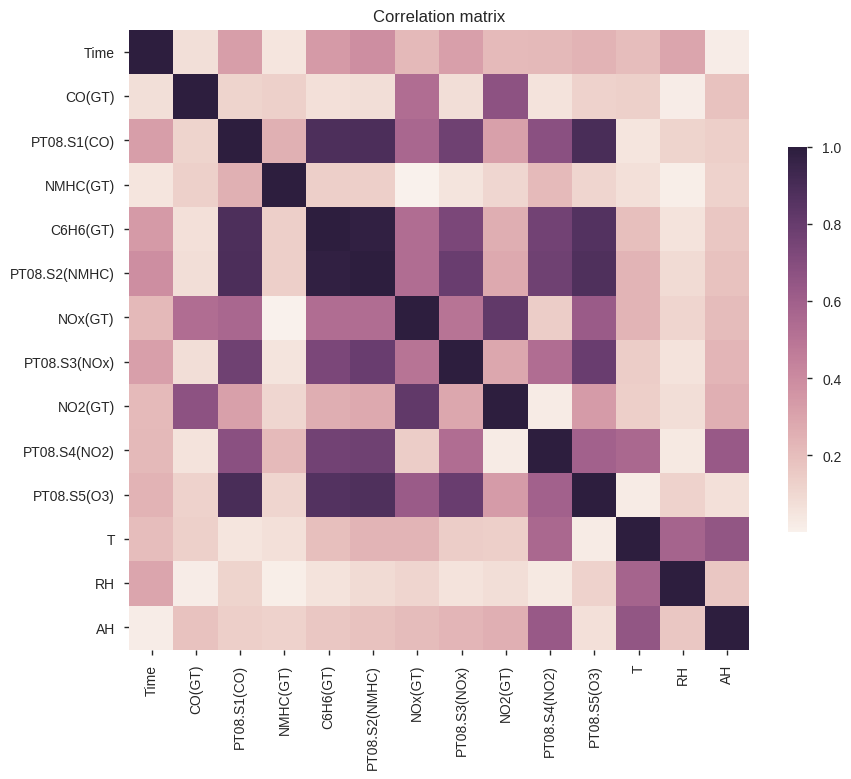

In [19]:
plt.figure(figsize=(10, 10))
corr = np.abs(df.corr())
ax = sns.heatmap(corr,  square=True, cbar_kws={"shrink": .5})  #center=0,
plt.title("Correlation matrix")

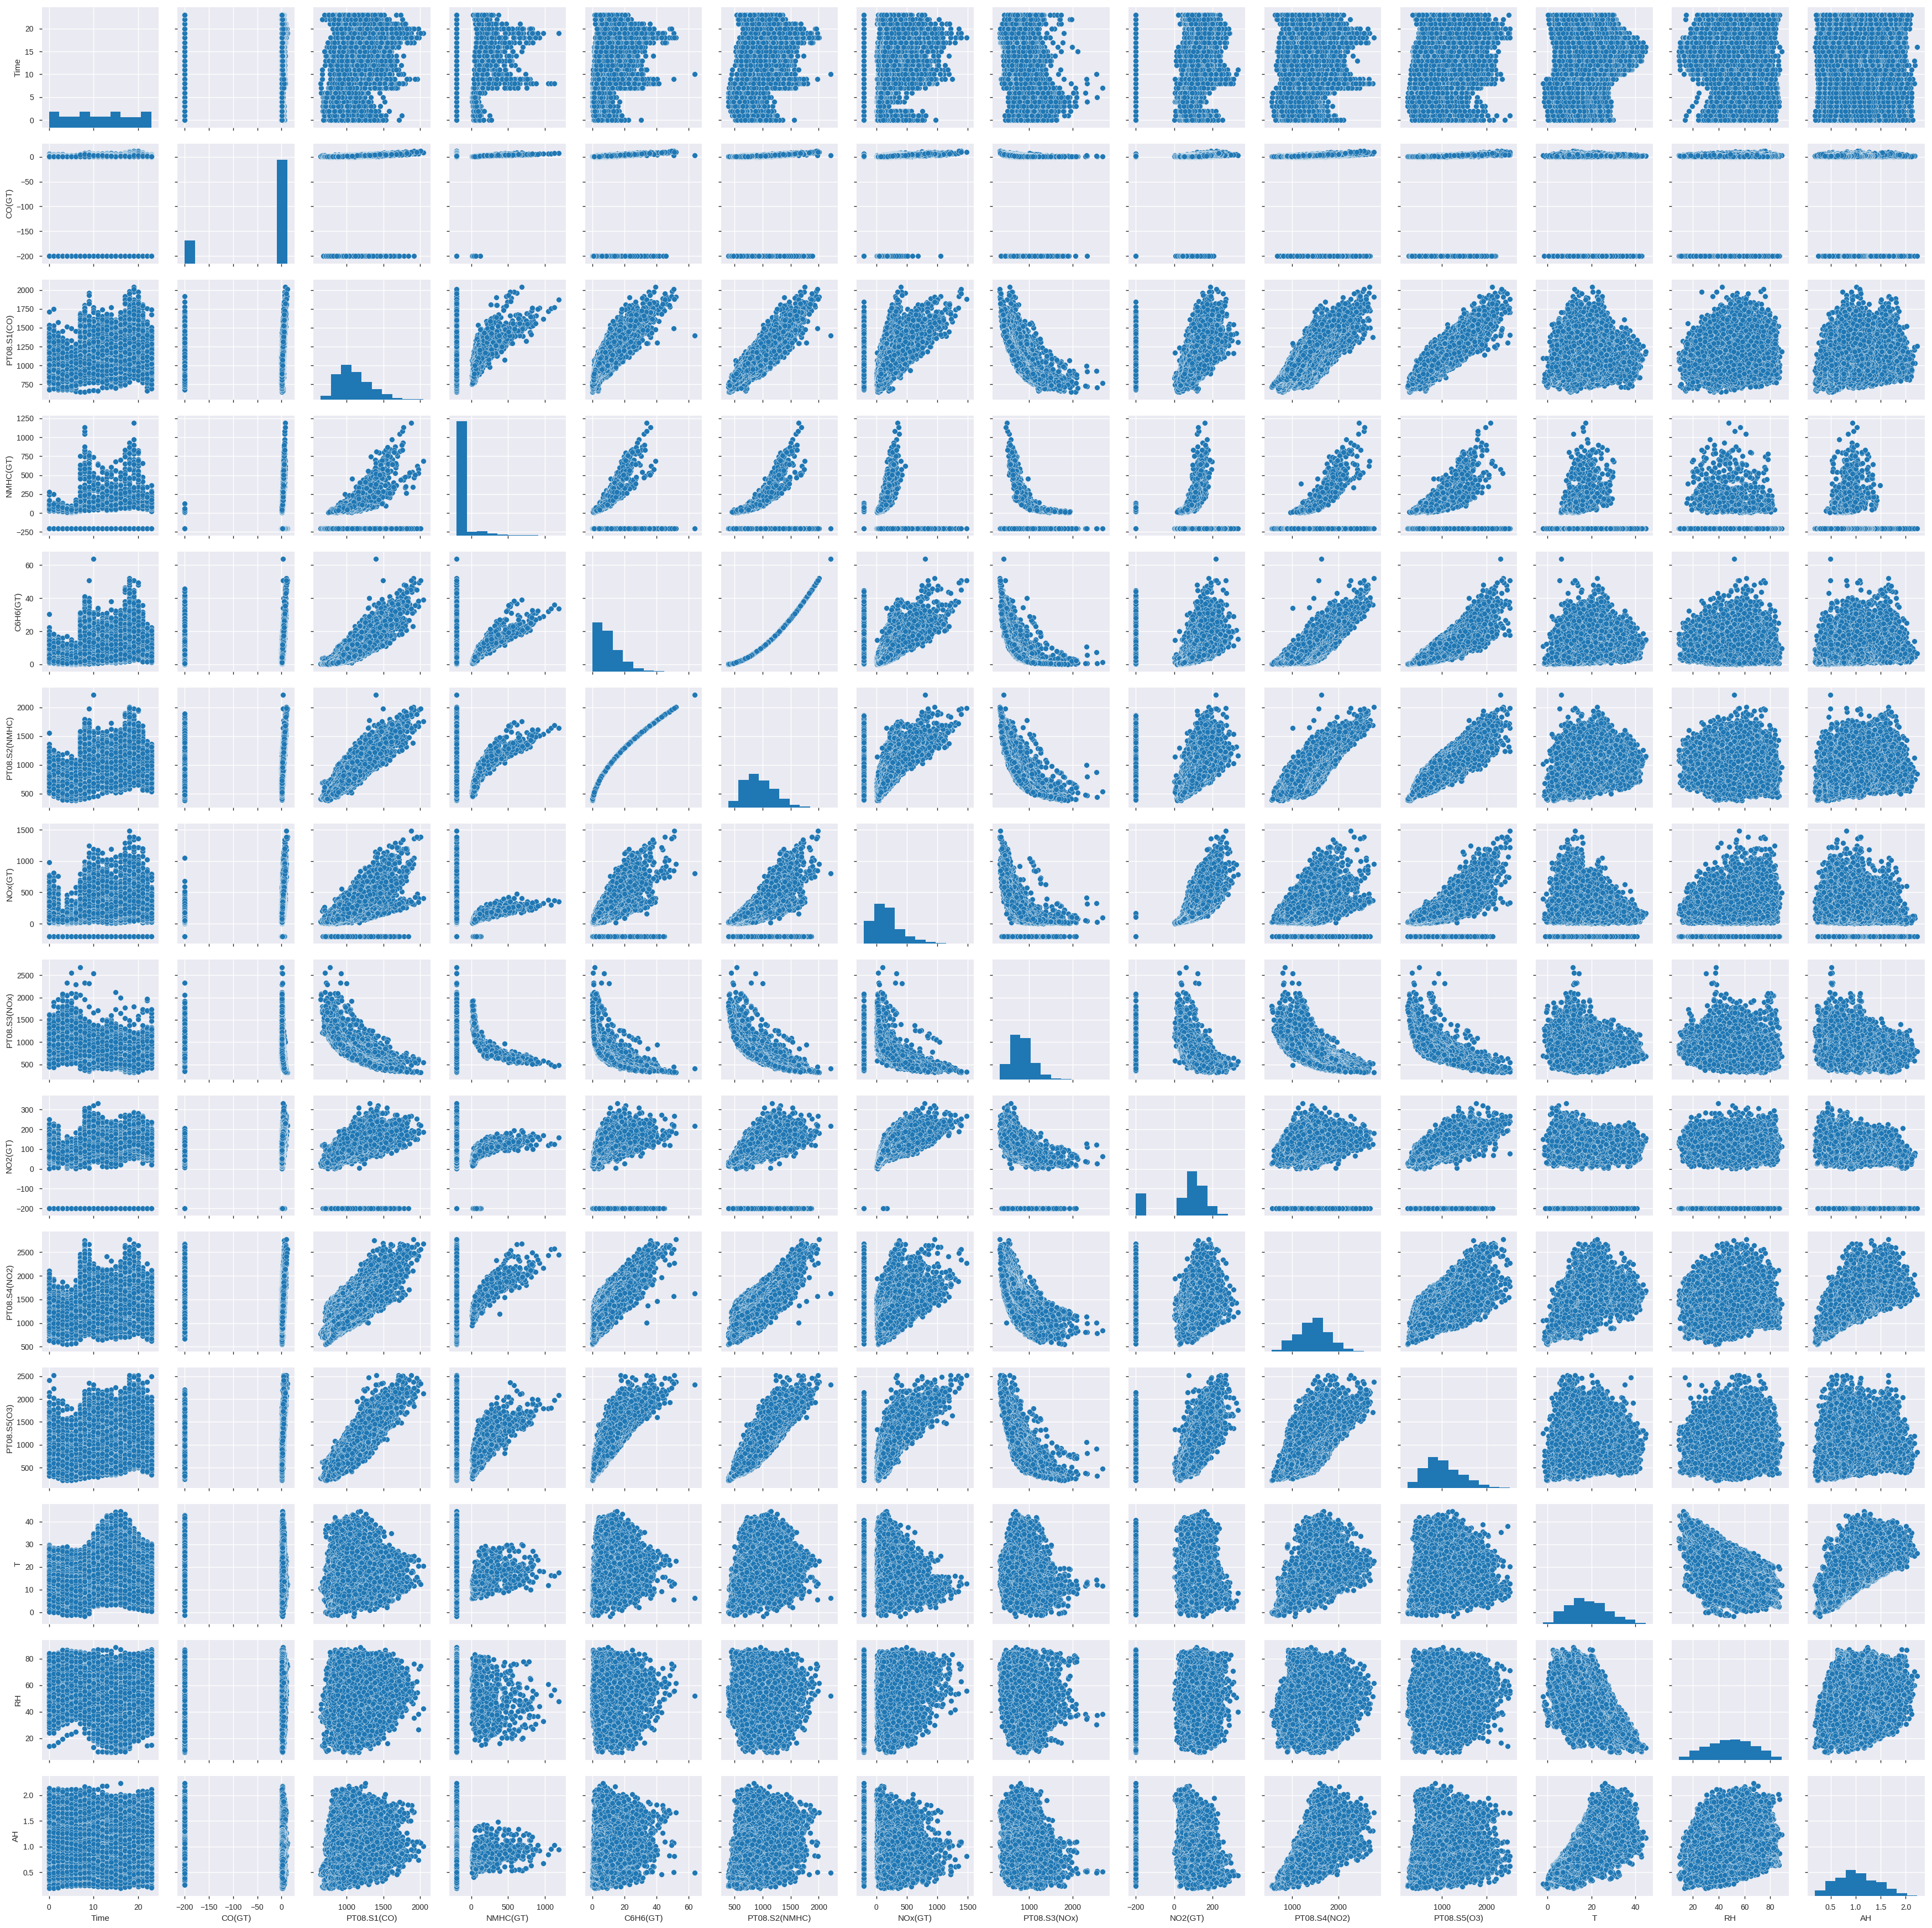

In [20]:
sns_plot = sns.pairplot(df)

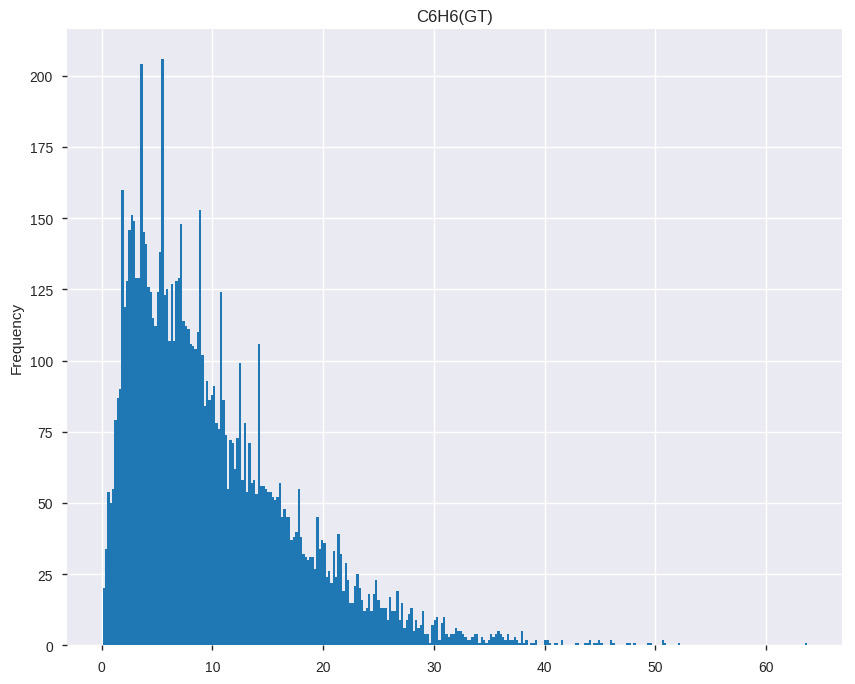

In [21]:
target = df["C6H6(GT)"]
target.plot.hist(bins = 300, figsize=(10, 8))
plt.title("C6H6(GT)")

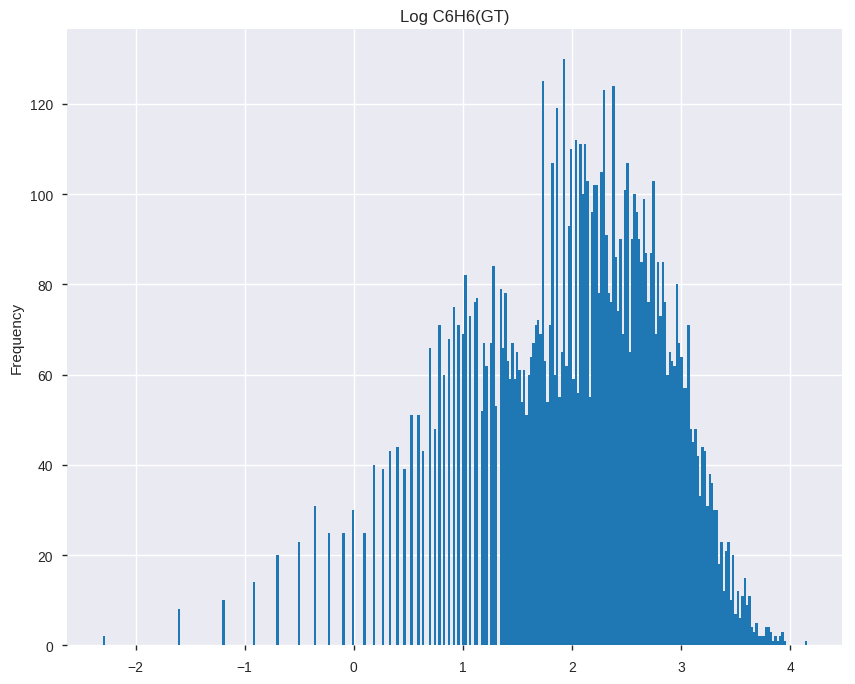

In [22]:
log_target = np.log(target)
log_target.plot.hist(bins = 300, figsize=(10, 8))
plt.title("Log C6H6(GT)")

In [23]:
float_df = df.select_dtypes(['float'])

In [24]:
float_df.head().T

0          1          2          3          4
CO(GT)            2.6000     2.0000     2.2000     2.2000     1.6000
PT08.S1(CO)    1360.0000  1292.0000  1402.0000  1376.0000  1272.0000
NMHC(GT)        150.0000   112.0000    88.0000    80.0000    51.0000
C6H6(GT)         11.9000     9.4000     9.0000     9.2000     6.5000
PT08.S2(NMHC)  1046.0000   955.0000   939.0000   948.0000   836.0000
NOx(GT)         166.0000   103.0000   131.0000   172.0000   131.0000
PT08.S3(NOx)   1056.0000  1174.0000  1140.0000  1092.0000  1205.0000
NO2(GT)         113.0000    92.0000   114.0000   122.0000   116.0000
PT08.S4(NO2)   1692.0000  1559.0000  1555.0000  1584.0000  1490.0000
PT08.S5(O3)    1268.0000   972.0000  1074.0000  1203.0000  1110.0000
T                13.6000    13.3000    11.9000    11.0000    11.2000
RH               48.9000    47.7000    54.0000    60.0000    59.6000
AH                0.7578     0.7255     0.7502     0.7867     0.7888

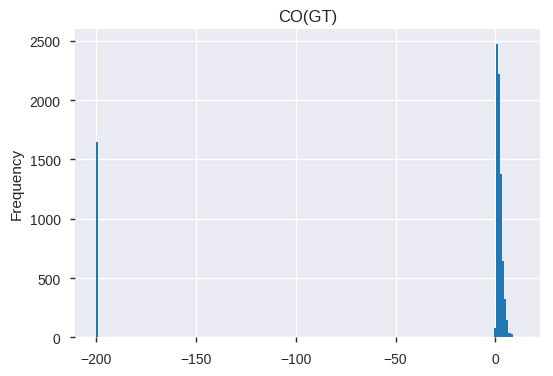

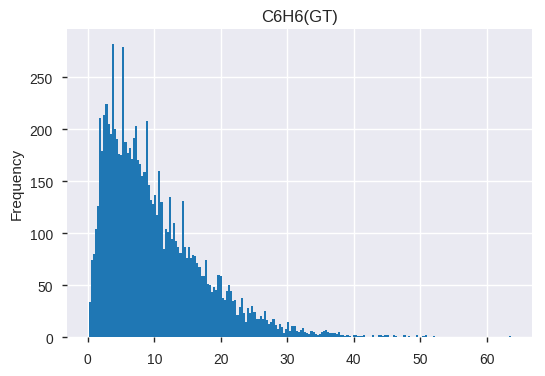

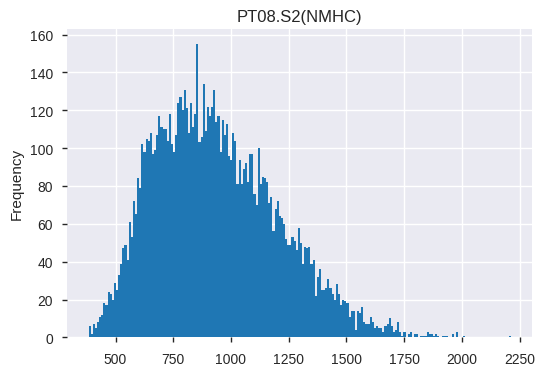

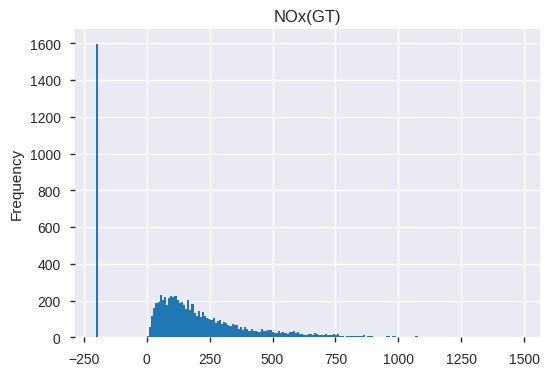

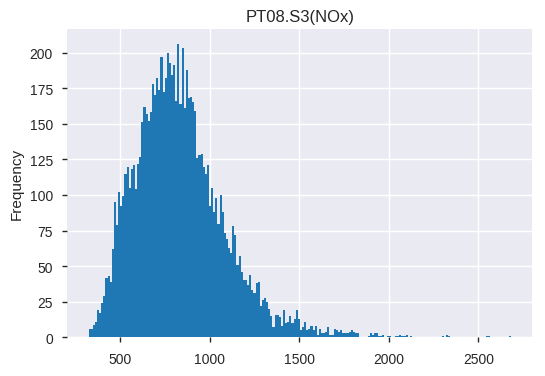

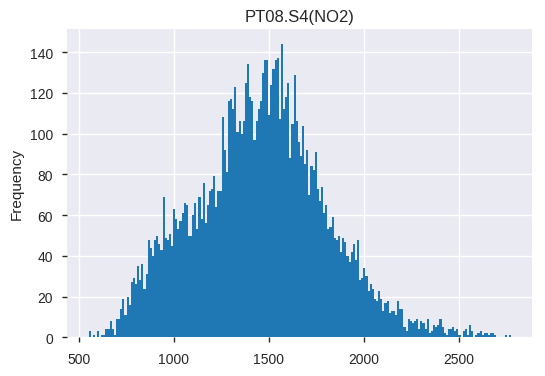

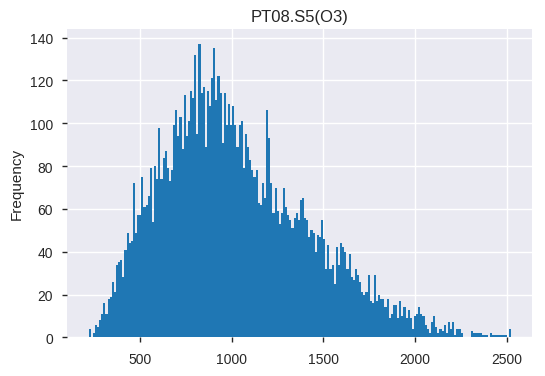

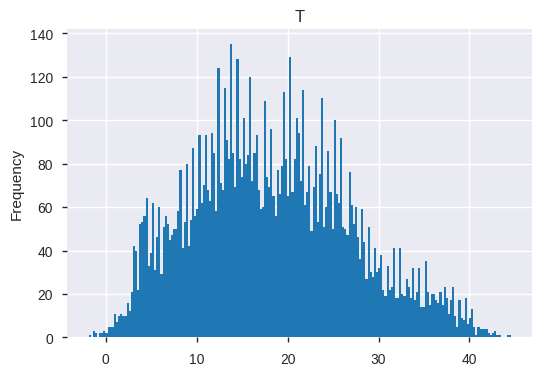

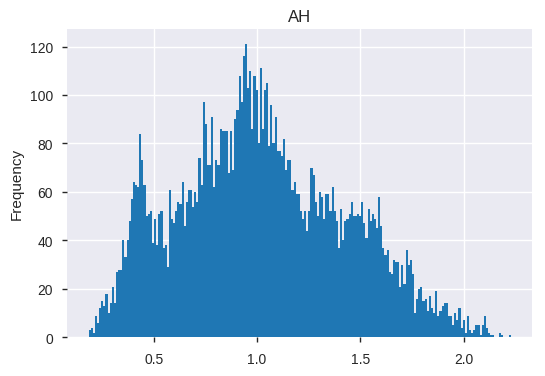

In [25]:
for i in list(float_df):
    
    plt.figure()  
    plt.title(i)
    float_df[i].plot.hist( bins=200, figsize=(6, 4))
    plt.show()

Let's take a closer look at NMHC(GT).

In [26]:
df["NMHC(GT)"].value_counts().head(10)

-200.0    8104
 66.0       13
 40.0        9
 29.0        9
 93.0        8
 88.0        8
 57.0        7
 84.0        7
 60.0        7
 95.0        7
Name: NMHC(GT), dtype: int64

Too many NaN's, let's drop it.

In [27]:
df = df.drop(["NMHC(GT)"], axis=1)

In [28]:
df.head().T

0                    1                    2  \
Date           2004-10-03 00:00:00  2004-10-03 00:00:00  2004-10-03 00:00:00   
Time                            18                   19                   20   
CO(GT)                         2.6                    2                  2.2   
PT08.S1(CO)                   1360                 1292                 1402   
C6H6(GT)                      11.9                  9.4                    9   
PT08.S2(NMHC)                 1046                  955                  939   
NOx(GT)                        166                  103                  131   
PT08.S3(NOx)                  1056                 1174                 1140   
NO2(GT)                        113                   92                  114   
PT08.S4(NO2)                  1692                 1559                 1555   
PT08.S5(O3)                   1268                  972                 1074   
T                             13.6                 13.3                 11.9   
RH                            48.9                 47.7                   54   
AH                          0.7578               0.7255               0.7502   

                                 3                    4  
Date           2004-10-03 00:00:00  2004-10-03 00:00:00  
Time                            21                   22  
CO(GT)                         2.2                  1.6  
PT08.S1(CO)                   1376                 1272  
C6H6(GT)                       9.2                  6.5  
PT08.S2(NMHC)                  948                  836  
NOx(GT)                        172                  131  
PT08.S3(NOx)                  1092                 1205  
NO2(GT)                        122                  116  
PT08.S4(NO2)                  1584                 1490  
PT08.S5(O3)                   1203                 1110  
T                               11                 11.2  
RH                              60                 59.6  
AH                          0.7867               0.7888

In [29]:
df.isin([-200]).any()

Date             False
Time             False
CO(GT)            True
PT08.S1(CO)      False
C6H6(GT)         False
PT08.S2(NMHC)    False
NOx(GT)           True
PT08.S3(NOx)     False
NO2(GT)           True
PT08.S4(NO2)     False
PT08.S5(O3)      False
T                False
RH               False
AH               False
dtype: bool

In [30]:
columns_with_NAN = df.select_dtypes(['float64']).columns[(df.select_dtypes(['float64']).isin([-200]).any() == True)].tolist()
columns_wo_NAN = df.select_dtypes(['float64']).columns[(df.select_dtypes(['float64']).isin([-200]).any() != True)].tolist()
columns_wo_NAN.remove('C6H6(GT)')

In [31]:
columns_wo_NAN

['PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'PT08.S3(NOx)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [32]:
columns_with_NAN

['CO(GT)', 'NOx(GT)', 'NO2(GT)']

## Skewness.

In [33]:
df[columns_wo_NAN].describe().T

count         mean         std       min        25%  \
PT08.S1(CO)    8991.0  1099.833166  217.080037  647.0000   937.0000   
PT08.S2(NMHC)  8991.0   939.153376  266.831429  383.0000   734.5000   
PT08.S3(NOx)   8991.0   835.493605  256.817320  322.0000   658.0000   
PT08.S4(NO2)   8991.0  1456.264598  346.206794  551.0000  1227.0000   
PT08.S5(O3)    8991.0  1022.906128  398.484288  221.0000   731.5000   
T              8991.0    18.317829    8.832116   -1.9000    11.8000   
RH             8991.0    49.234201   17.316892    9.2000    35.8000   
AH             8991.0     1.025530    0.403813    0.1847     0.7368   

                     50%        75%       max  
PT08.S1(CO)    1063.0000  1231.0000  2040.000  
PT08.S2(NMHC)   909.0000  1116.0000  2214.000  
PT08.S3(NOx)    806.0000   969.5000  2683.000  
PT08.S4(NO2)   1463.0000  1674.0000  2775.000  
PT08.S5(O3)     963.0000  1273.5000  2523.000  
T                17.8000    24.4000    44.600  
RH               49.6000    62.5000    88.700  
AH                0.9954     1.3137     2.231

In [34]:
skewed_feats = df[columns_wo_NAN].apply(lambda x: skew(x)) 

In [35]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats

PT08.S1(CO)     0.755781
PT08.S3(NOx)    1.101545
dtype: float64

In [36]:
skewed_feats = skewed_feats.index
df[skewed_feats] = np.log1p(df[skewed_feats])  

In [37]:
df[columns_wo_NAN].describe().T

count         mean         std         min          25%  \
PT08.S1(CO)    8991.0     6.985292    0.190835    6.473891     6.843750   
PT08.S2(NMHC)  8991.0   939.153376  266.831429  383.000000   734.500000   
PT08.S3(NOx)   8991.0     6.684777    0.297605    5.777652     6.490724   
PT08.S4(NO2)   8991.0  1456.264598  346.206794  551.000000  1227.000000   
PT08.S5(O3)    8991.0  1022.906128  398.484288  221.000000   731.500000   
T              8991.0    18.317829    8.832116   -1.900000    11.800000   
RH             8991.0    49.234201   17.316892    9.200000    35.800000   
AH             8991.0     1.025530    0.403813    0.184700     0.736800   

                       50%          75%          max  
PT08.S1(CO)       6.969791     7.116394     7.621195  
PT08.S2(NMHC)   909.000000  1116.000000  2214.000000  
PT08.S3(NOx)      6.693324     6.877811     7.895063  
PT08.S4(NO2)   1463.000000  1674.000000  2775.000000  
PT08.S5(O3)     963.000000  1273.500000  2523.000000  
T                17.800000    24.400000    44.600000  
RH               49.600000    62.500000    88.700000  
AH                0.995400     1.313700     2.231000

## Features generation.

### Month and Daytime.

In [38]:
time_dict = dict.fromkeys([22, 23, 0, 1, 2, 3], "night")
time_dict.update(dict.fromkeys([a for a in range(4, 10)], "morning"))
time_dict.update(dict.fromkeys([a for a in range(10, 16)], "day"))
time_dict.update(dict.fromkeys([a for a in range(16, 22)], "evening"))

df["Daytime"] = df["Time"].map(lambda x: time_dict[x])

df["Month"] = df["Date"].map(lambda x: x.month)
df = df.replace({ "Month" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 
                             7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                })

In [39]:
df.Date.max()

Timestamp('2005-12-03 00:00:00')

In [40]:
df.Date.min()

Timestamp('2004-01-04 00:00:00')

In [41]:
df = pd.get_dummies(df)

In [42]:
df.head().T

0                    1  \
Date             2004-10-03 00:00:00  2004-10-03 00:00:00   
Time                              18                   19   
CO(GT)                           2.6                    2   
PT08.S1(CO)                  7.21598              7.16472   
C6H6(GT)                        11.9                  9.4   
PT08.S2(NMHC)                   1046                  955   
NOx(GT)                          166                  103   
PT08.S3(NOx)                 6.96319              7.06902   
NO2(GT)                          113                   92   
PT08.S4(NO2)                    1692                 1559   
PT08.S5(O3)                     1268                  972   
T                               13.6                 13.3   
RH                              48.9                 47.7   
AH                            0.7578               0.7255   
Daytime_day                        0                    0   
Daytime_evening                    1                    1   
Daytime_morning                    0                    0   
Daytime_night                      0                    0   
Month_Apr                          0                    0   
Month_Aug                          0                    0   
Month_Dec                          0                    0   
Month_Feb                          0                    0   
Month_Jan                          0                    0   
Month_Jul                          0                    0   
Month_Jun                          0                    0   
Month_Mar                          0                    0   
Month_May                          0                    0   
Month_Nov                          0                    0   
Month_Oct                          1                    1   
Month_Sep                          0                    0   

                                   2                    3                    4  
Date             2004-10-03 00:00:00  2004-10-03 00:00:00  2004-10-03 00:00:00  
Time                              20                   21                   22  
CO(GT)                           2.2                  2.2                  1.6  
PT08.S1(CO)                  7.24637              7.22766              7.14913  
C6H6(GT)                           9                  9.2                  6.5  
PT08.S2(NMHC)                    939                  948                  836  
NOx(GT)                          131                  172                  131  
PT08.S3(NOx)                 7.03966              6.99668              7.09506  
NO2(GT)                          114                  122                  116  
PT08.S4(NO2)                    1555                 1584                 1490  
PT08.S5(O3)                     1074                 1203                 1110  
T                               11.9                   11                 11.2  
RH                                54                   60                 59.6  
AH                            0.7502               0.7867               0.7888  
Daytime_day                        0                    0                    0  
Daytime_evening                    1                    1                    0  
Daytime_morning                    0                    0                    0  
Daytime_night                      0                    0                    1  
Month_Apr                          0                    0                    0  
Month_Aug                          0                    0                    0  
Month_Dec                          0                    0                    0  
Month_Feb                          0                    0                    0  
Month_Jan                          0                    0                    0  
Month_Jul                          0                    0                    0  
Month_Jun                          0                    0                    0  
Month_Mar                          0 

### Polinomial features.

In [43]:
df.pop("C6H6(GT)");

In [44]:
for i in columns_wo_NAN:
    df[i + "_2"] = df[i] ** 2
    df[i + "_3"] = df[i] ** 3
    df["sqrt_" + i] = np.sqrt(df[i])
    df["log_" + i] = np.log(df[i])

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8991 entries, 0 to 9356
Data columns (total 61 columns):
Date                  8991 non-null datetime64[ns]
Time                  8991 non-null int64
CO(GT)                8991 non-null float64
PT08.S1(CO)           8991 non-null float64
PT08.S2(NMHC)         8991 non-null float64
NOx(GT)               8991 non-null float64
PT08.S3(NOx)          8991 non-null float64
NO2(GT)               8991 non-null float64
PT08.S4(NO2)          8991 non-null float64
PT08.S5(O3)           8991 non-null float64
T                     8991 non-null float64
RH                    8991 non-null float64
AH                    8991 non-null float64
Daytime_day           8991 non-null uint8
Daytime_evening       8991 non-null uint8
Daytime_morning       8991 non-null uint8
Daytime_night         8991 non-null uint8
Month_Apr             8991 non-null uint8
Month_Aug             8991 non-null uint8
Month_Dec             8991 non-null uint8
Month_Feb             

In [46]:
df = df.drop(["sqrt_T", "log_T"], axis=1)

## Filling the NaN's.

In [47]:
columns_with_NAN

['CO(GT)', 'NOx(GT)', 'NO2(GT)']

In [48]:
tar_names = []

for i in columns_with_NAN:
    tar_names.append("target_" + i.split("(")[0]) 
    
for i, k in enumerate(tar_names):
    print(i, k, columns_with_NAN[i])
    k = df[columns_with_NAN[i]]

0 target_CO CO(GT)
1 target_NOx NOx(GT)
2 target_NO2 NO2(GT)


In [49]:
target_CO = df["CO(GT)"]
target_NOx = df["NOx(GT)"] 
target_NO2 = df["NO2(GT)"]

### target_CO

In [50]:
target_CO.value_counts().head()

-200.0    1647
 1.0       287
 1.4       269
 1.5       265
 1.6       264
Name: CO(GT), dtype: int64

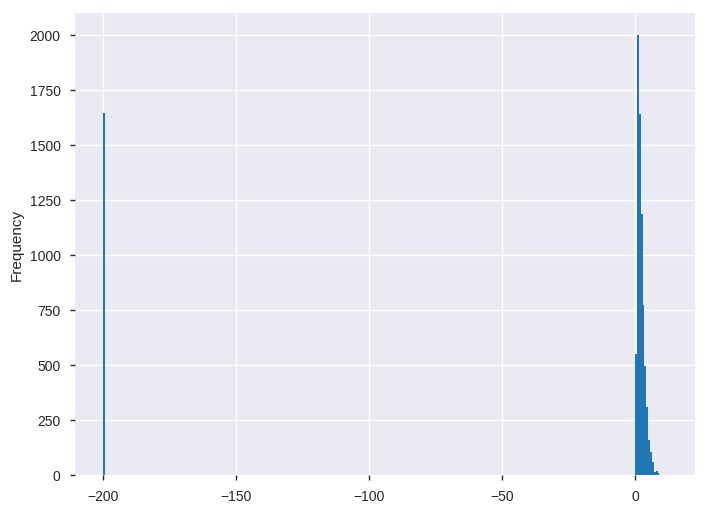

In [51]:
target_CO.plot.hist(bins = 300, figsize=(8, 6))

In [52]:
index_CO_NAN = target_CO[target_CO == -200].index
index_CO = target_CO[target_CO != -200].index

mean_CO = target_CO[target_CO != -200].mean()
mean_CO

2.1297113289760343

In [53]:
target_CO_mean = target_CO.replace(-200, mean_CO)

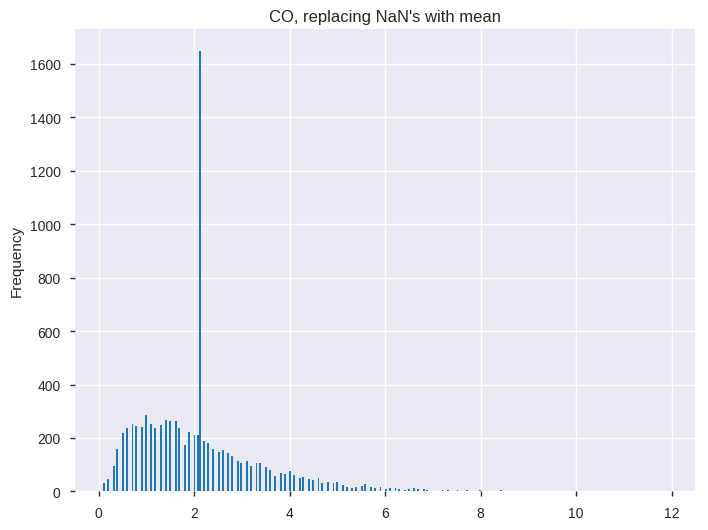

In [54]:
target_CO_mean.plot.hist(bins = 300, figsize=(8, 6))
plt.title("CO, replacing NaN's with mean")

In [55]:
df_train_CO = df[columns_wo_NAN][df.index.isin(index_CO)]
df_test_CO = df[columns_wo_NAN][df.index.isin(index_CO_NAN)]

y_CO = target_CO[df.index.isin(index_CO)]

scaler = StandardScaler()
train_CO_scl = scaler.fit_transform(df_train_CO.values)

In [56]:
def Lasso_alpha_tuning(X, y, metric="r2"):
    alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]

    cv_lasso = [score_cv(Lasso(alpha=alpha, random_state=random_state), metric, X, y).mean() for alpha in alphas]

    cv_lasso = pd.Series(cv_lasso, index = alphas)
    title = "Alpha tuning Lasso, metric: " + metric
    cv_lasso.plot(title = title)
    plt.xlabel("alpha")
    plt.ylabel(metric)

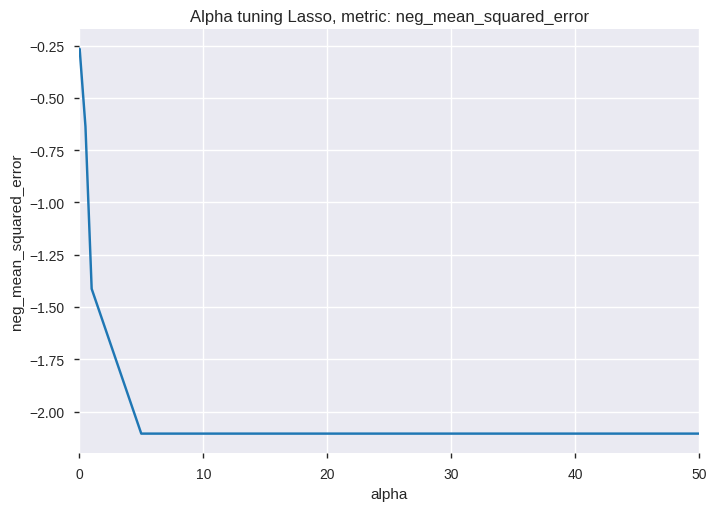

In [57]:
Lasso_alpha_tuning(train_CO_scl, y_CO, "neg_mean_squared_error")

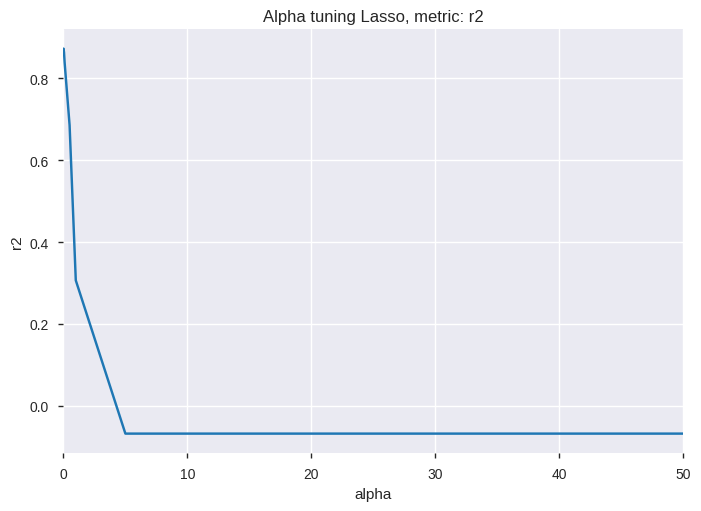

In [58]:
Lasso_alpha_tuning(train_CO_scl, y_CO )

In [59]:
%%time
linreg = Lasso( alpha=0.05, random_state=random_state)

cvs = []
for metric in scoring:
    cvs.append(cross_val_score(linreg, train_CO_scl, y_CO, cv=5, scoring=metric))
    
print(linreg, "\n")

for i in range(len(scoring)):
    print("%s %0.5f" % (scoring[i], cvs[i].mean()))
print("\n")

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.35947
neg_mean_squared_error -0.27980
neg_median_absolute_error -0.25842
r2 0.86375


CPU times: user 316 ms, sys: 8 ms, total: 324 ms
Wall time: 110 ms


(-3, 10)

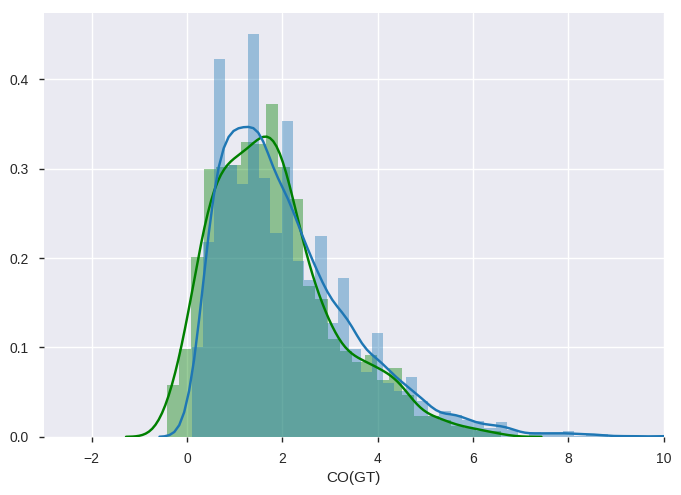

In [60]:
linreg.fit(train_CO_scl, y_CO)
predicted_CO = linreg.predict( scaler.transform(df_test_CO.values))

sns.distplot(predicted_CO, color="g")
sns.distplot(y_CO)
sns.plt.xlim(-3, 10)

In [61]:
predcted_target_CO = target_CO.copy()

predcted_target_CO[predcted_target_CO == -200] = predicted_CO

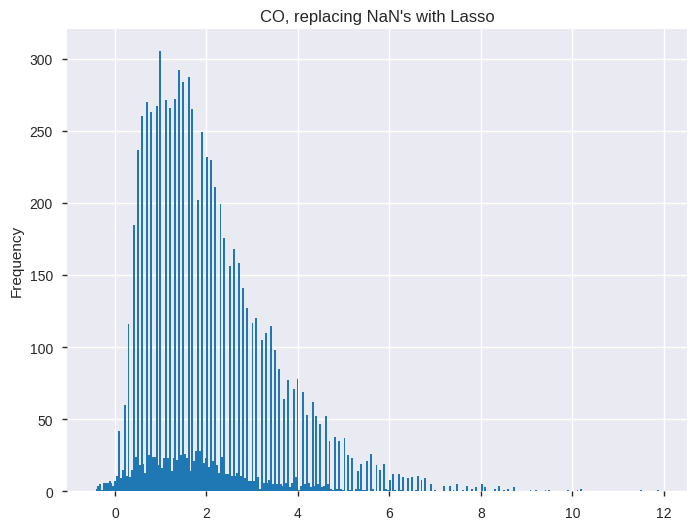

In [62]:
predcted_target_CO.plot.hist(bins = 300, figsize=(8, 6))
plt.title("CO, replacing NaN's with Lasso")

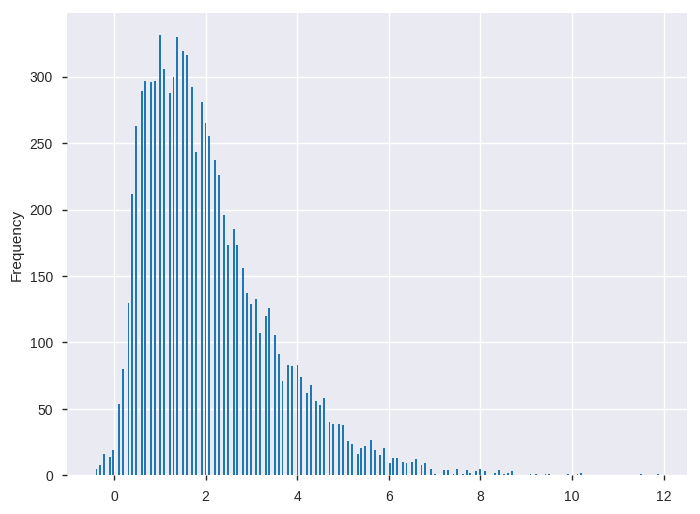

In [63]:
predcted_target_CO.round(1).plot.hist(bins = 300, figsize=(8, 6))

### target_NOx

In [64]:
target_NOx.value_counts().head()

-200.0    1595
 89.0       39
 93.0       36
 122.0      35
 132.0      35
Name: NOx(GT), dtype: int64

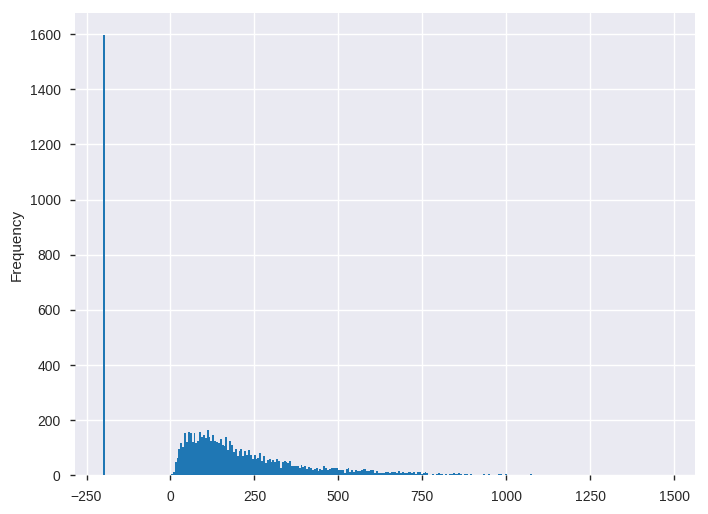

In [65]:
target_NOx.plot.hist(bins = 300, figsize=(8, 6))

In [66]:
index_NOx_NAN = target_NOx[target_NOx == -200].index
index_NOx = target_NOx[target_NOx != -200].index

In [67]:
df_train_NOx = df[columns_wo_NAN][df.index.isin(index_NOx)]
df_test_NOx = df[columns_wo_NAN][df.index.isin(index_NOx_NAN)]

y_NOx = target_NOx[df.index.isin(index_NOx)]
print( df_train_NOx.shape, df_test_NOx.shape, y_NOx.shape)

scaler = StandardScaler()
train_NOx_scl = scaler.fit_transform(df_train_NOx.values)

(7396, 8) (1595, 8) (7396,)


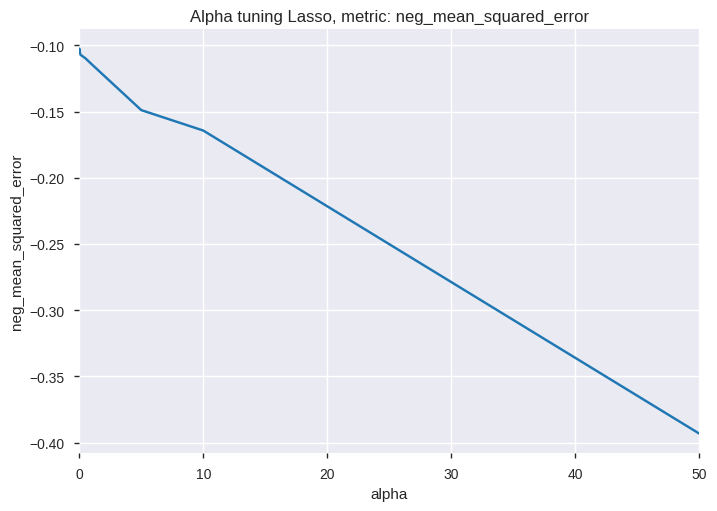

In [68]:
Lasso_alpha_tuning(df_train_NOx.values, np.log(y_NOx), "neg_mean_squared_error")

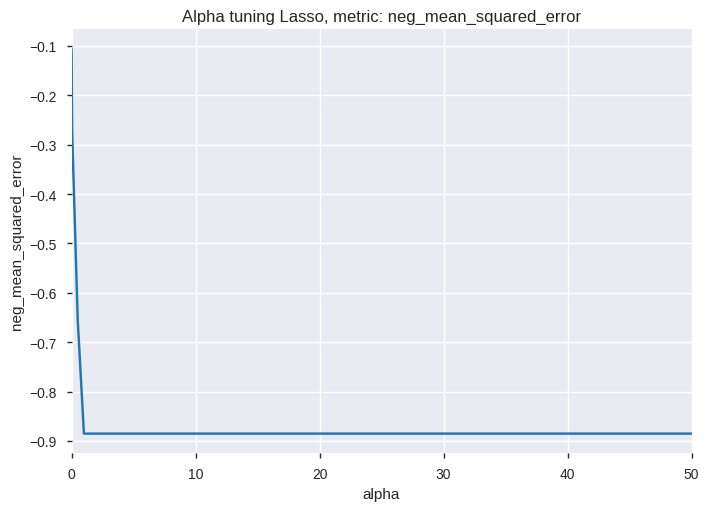

In [69]:
Lasso_alpha_tuning(train_NOx_scl, np.log(y_NOx), "neg_mean_squared_error")

In [70]:
%%time
linreg = Lasso( alpha=0.0001, random_state=random_state)

cvs = []
for metric in scoring:
    cvs.append(cross_val_score(linreg, train_NOx_scl, np.log(y_NOx), cv=5, scoring=metric))
    
print(linreg, "\n")

for i in range(len(scoring)):
    print("%s %0.5f" % (scoring[i], cvs[i].mean()))
print("\n")

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.24598
neg_mean_squared_error -0.10543
neg_median_absolute_error -0.20313
r2 0.81021


CPU times: user 1.1 s, sys: 8 ms, total: 1.11 s
Wall time: 396 ms


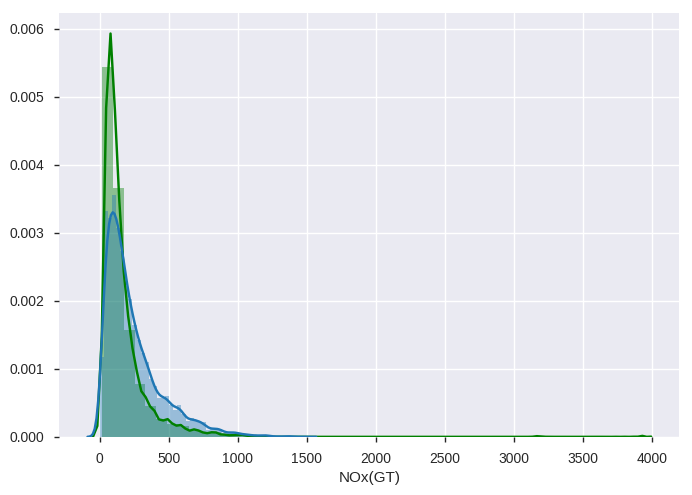

In [71]:
linreg.fit(train_NOx_scl, np.log(y_NOx))
predicted_NOx = linreg.predict( scaler.transform(df_test_NOx.values))

sns.distplot( np.exp(predicted_NOx), color="g")
sns.distplot(y_NOx)
#sns.plt.xlim(0, 10)

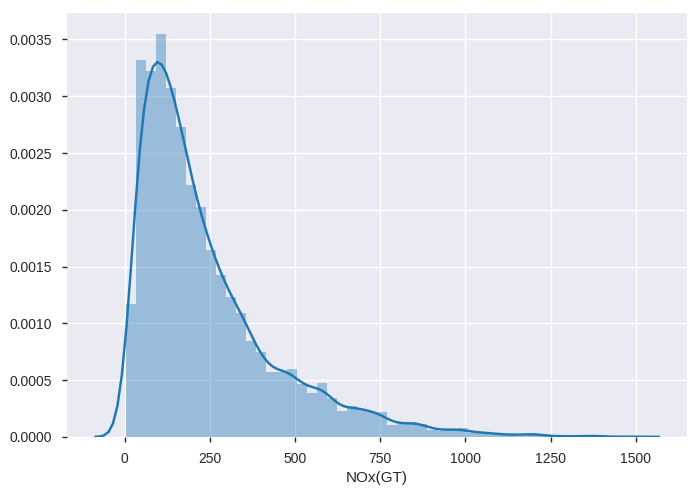

In [72]:
sns.distplot(y_NOx, norm_hist=False)

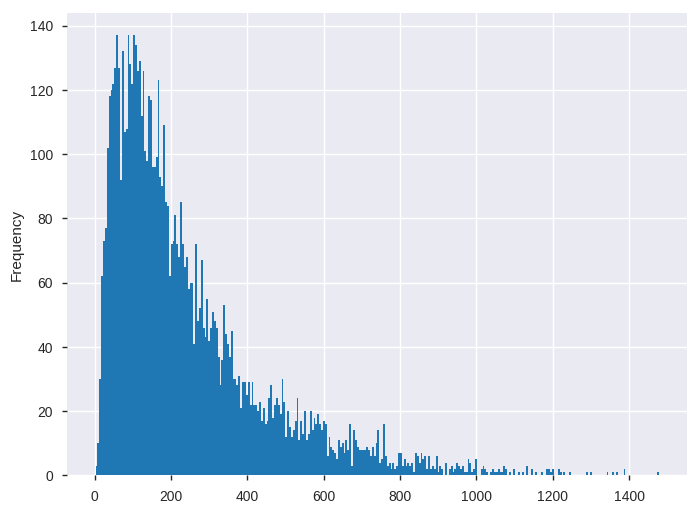

In [73]:
y_NOx.plot.hist(bins = 300, figsize=(8, 6))

### target_NO2

In [74]:
target_NO2.value_counts().head()

-200.0    1598
 97.0       76
 119.0      74
 101.0      74
 114.0      74
Name: NO2(GT), dtype: int64

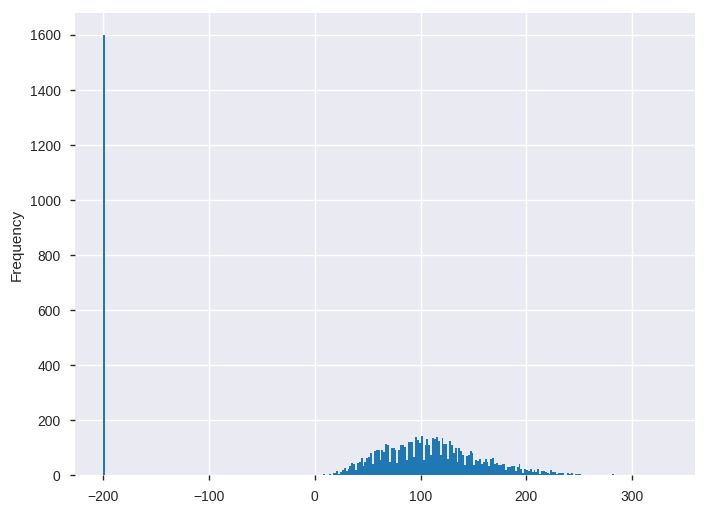

In [75]:
target_NO2.plot.hist(bins = 300, figsize=(8, 6))

In [76]:
index_NO2_NAN = target_NO2[target_NO2 == -200].index
index_NO2 = target_NO2[target_NO2 != -200].index

In [77]:
df_train_NO2 = df[columns_wo_NAN][df.index.isin(index_NO2)]
df_test_NO2 = df[columns_wo_NAN][df.index.isin(index_NO2_NAN)]

y_NO2 = target_NO2[df.index.isin(index_NO2)]
print( df_train_NO2.shape, df_test_NO2.shape, y_NO2.shape)

scaler = StandardScaler()
train_NO2_scl = scaler.fit_transform(df_train_NO2.values)

(7393, 8) (1598, 8) (7393,)


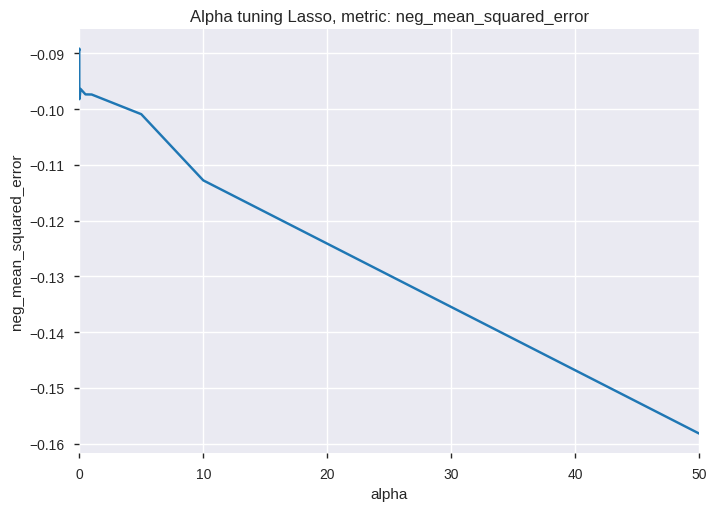

In [78]:
Lasso_alpha_tuning(df_train_NO2.values, np.log(y_NO2), "neg_mean_squared_error")

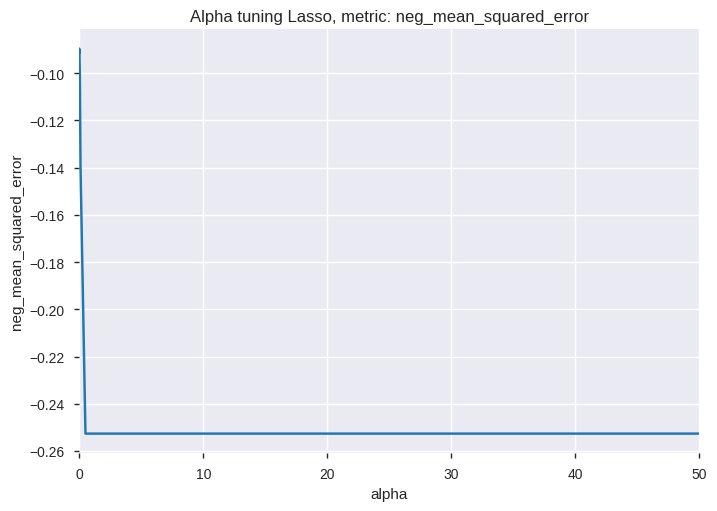

In [79]:
Lasso_alpha_tuning(train_NO2_scl, np.log(y_NO2), "neg_mean_squared_error")

In [80]:
%%time
linreg = Lasso( alpha=0.00001, random_state=random_state)

cvs = []
for metric in scoring:
    cvs.append(cross_val_score(linreg, train_NO2_scl, np.log(y_NO2), cv=5, scoring=metric))
    
print(linreg, "\n")

for i in range(len(scoring)):
    print("%s %0.5f" % (scoring[i], cvs[i].mean()))
print("\n")

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.22831
neg_mean_squared_error -0.08959
neg_median_absolute_error -0.19657
r2 0.55516


CPU times: user 1.02 s, sys: 8 ms, total: 1.02 s
Wall time: 347 ms


(2, 7)

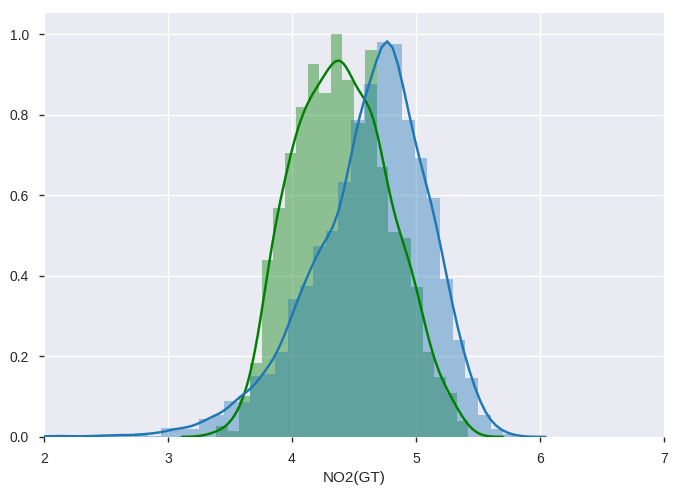

In [81]:
linreg.fit(train_NO2_scl, np.log(y_NO2))
predicted_NO2 = linreg.predict( scaler.transform(df_test_NO2.values))

sns.distplot(predicted_NO2, color="g")
sns.distplot(np.log(y_NO2))
sns.plt.xlim(2, 7)

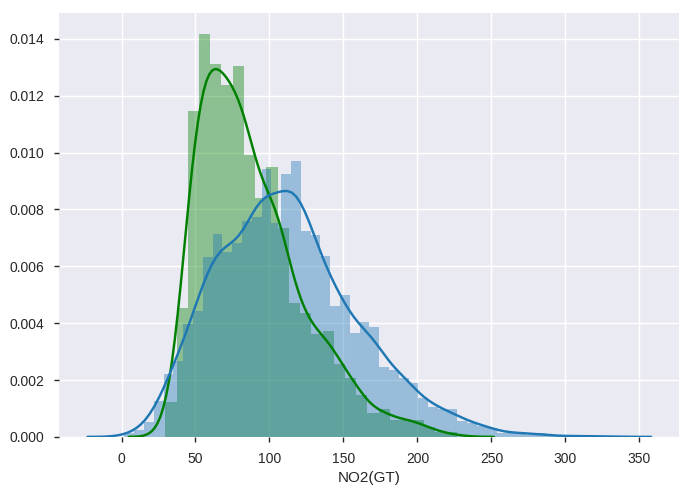

In [82]:
sns.distplot( np.exp(predicted_NO2), color="g")
sns.distplot(y_NO2)
#sns.plt.xlim(2, 7)

## Merging, splitting, scaling.

In [83]:
df = pd.concat([df, predcted_target_CO], axis=1)

In [84]:
df.head().T

0                    1  \
Date                2004-10-03 00:00:00  2004-10-03 00:00:00   
Time                                 18                   19   
CO(GT)                              2.6                    2   
PT08.S1(CO)                     7.21598              7.16472   
PT08.S2(NMHC)                      1046                  955   
NOx(GT)                             166                  103   
PT08.S3(NOx)                    6.96319              7.06902   
NO2(GT)                             113                   92   
PT08.S4(NO2)                       1692                 1559   
PT08.S5(O3)                        1268                  972   
T                                  13.6                 13.3   
RH                                 48.9                 47.7   
AH                               0.7578               0.7255   
Daytime_day                           0                    0   
Daytime_evening                       1                    1   
Daytime_morning                       0                    0   
Daytime_night                         0                    0   
Month_Apr                             0                    0   
Month_Aug                             0                    0   
Month_Dec                             0                    0   
Month_Feb                             0                    0   
Month_Jan                             0                    0   
Month_Jul                             0                    0   
Month_Jun                             0                    0   
Month_Mar                             0                    0   
Month_May                             0                    0   
Month_Nov                             0                    0   
Month_Oct                             1                    1   
Month_Sep                             0                    0   
PT08.S1(CO)_2                   52.0703              51.3332   
PT08.S1(CO)_3                   375.738              367.788   
sqrt_PT08.S1(CO)                2.68626               2.6767   
log_PT08.S1(CO)                  1.9763              1.96917   
PT08.S2(NMHC)_2             1.09412e+06               912025   
PT08.S2(NMHC)_3             1.14445e+09          8.70984e+08   
sqrt_PT08.S2(NMHC)              32.3419              30.9031   
log_PT08.S2(NMHC)               6.95273              6.86171   
PT08.S3(NOx)_2                   48.486              49.9711   
PT08.S3(NOx)_3                  337.617              353.247   
sqrt_PT08.S3(NOx)               2.63879              2.65876   
log_PT08.S3(NOx)                1.94064              1.95572   
PT08.S4(NO2)_2              2.86286e+06          2.43048e+06   
PT08.S4(NO2)_3              4.84397e+09          3.78912e+09   
sqrt_PT08.S4(NO2)               41.1339              39.4842   
log_PT08.S4(NO2)                7.43367               7.3518   
PT08.S5(O3)_2               1.60782e+06               944784   
PT08.S5(O3)_3               2.03872e+09           9.1833e+08   
sqrt_PT08.S5(O3)                 35.609              31.1769   
log_PT08.S5(O3)                  7.1452              6.87936   
T_2                              184.96               176.89   
T_3                             2515.46              2352.64   
RH_2                            2391.21              2275.29   
RH_3                             116930               108531   
sqrt_RH                         6.99285              6.90652   
log_RH                          3.88978              3.86493   
AH_2                           0.574261              0.52635   
AH_3                           0.435175             0.381867   
sqrt_AH                        0.870517             0.851763   
log_AH                        -0.277336            -0.320894   
CO(GT)                              2.6                    2   

                                      2                    3  \
Date                2004-10-03 00:00:00  2004-10-03 00:00:00   
Time 

In [91]:
df.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
       'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH',
       'Daytime_day', 'Daytime_evening', 'Daytime_morning', 'Daytime_night',
       'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan',
       'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'PT08.S1(CO)_2', 'PT08.S1(CO)_3',
       'sqrt_PT08.S1(CO)', 'log_PT08.S1(CO)', 'PT08.S2(NMHC)_2',
       'PT08.S2(NMHC)_3', 'sqrt_PT08.S2(NMHC)', 'log_PT08.S2(NMHC)',
       'PT08.S3(NOx)_2', 'PT08.S3(NOx)_3', 'sqrt_PT08.S3(NOx)',
       'log_PT08.S3(NOx)', 'PT08.S4(NO2)_2', 'PT08.S4(NO2)_3',
       'sqrt_PT08.S4(NO2)', 'log_PT08.S4(NO2)', 'PT08.S5(O3)_2',
       'PT08.S5(O3)_3', 'sqrt_PT08.S5(O3)', 'log_PT08.S5(O3)', 'T_2', 'T_3',
       'RH_2', 'RH_3', 'sqrt_RH', 'log_RH', 'AH_2', 'AH_3', 'sqrt_AH',
       'log_AH', 'CO(GT)'],
      dtype='object')

In [85]:
df.shape[0] *0.7

6293.7

In [87]:
df_train = df[ df.Date < '2004-12-01']

mask = df_train.index

df_train.shape

(6266, 60)

In [89]:
df[df.index.isin(mask)].shape

(6266, 60)

In [90]:
df = df.drop(["Date", "Time"], axis=1)

In [94]:
def split_func(data_frame, target_var, mask, scale=False):
    
    X_train = data_frame[data_frame.index.isin(mask)].values
    X_test = data_frame[~data_frame.index.isin(mask)].values
    y_train = target_var[data_frame.index.isin(mask)]
    y_test = target_var[~data_frame.index.isin(mask)]
    
    print("X_train : " + str(X_train.shape))
    print("X_val : " + str(X_test.shape))
    print("y_train : " + str(y_train.shape))
    print("y_val : " + str(y_test.shape))
    
    if scale == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [95]:
X_BaseLine_train,
X_test,
y_train,
y_test = split_func(df[columns_wo_NAN], target, mask)

X_train : (6266, 8)
X_val : (2725, 8)
y_train : (6266,)
y_val : (2725,)


In [102]:
X_BaseLine_train_scl,
X_BaseLine_test_scl,
y_log_train,
y_log_test = split_func(df[columns_wo_NAN],
                        log_target, mask, scale=True)

X_train : (6266, 8)
X_val : (2725, 8)
y_train : (6266,)
y_val : (2725,)


In [140]:
columns_base_and_time = list(df.columns[:27])
columns_base_and_time

['CO(GT)',
 'PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH',
 'Daytime_day',
 'Daytime_evening',
 'Daytime_morning',
 'Daytime_night',
 'Month_Apr',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jan',
 'Month_Jul',
 'Month_Jun',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep']

In [141]:
X_time_train,
X_time_test,
y_train,
y_test = split_func(df[columns_base_and_time], target, mask)

X_time_train_scl,
X_time_test_scl,
y_train,
y_test = split_func(df[columns_base_and_time],
                    target, mask, scale=True)

X_train : (6266, 28)
X_val : (2725, 28)
y_train : (6266,)
y_val : (2725,)
X_train : (6266, 28)
X_val : (2725, 28)
y_train : (6266,)
y_val : (2725,)


In [142]:
X_all_train, X_all_test, y_train, y_test = split_func(df, target, mask)

X_all_train_scl,
X_all_test_scl,
y_train,
y_test = split_func(df, target, mask, scale=True)

X_train : (6266, 58)
X_val : (2725, 58)
y_train : (6266,)
y_val : (2725,)
X_train : (6266, 58)
X_val : (2725, 58)
y_train : (6266,)
y_val : (2725,)


# Trying different models.

## Lasso.

### Base.

In [125]:
%%time
linreg = Lasso(random_state=random_state)

model_fit_print_metr(linreg, X_BaseLine_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.96688
neg_mean_squared_error -2.22236
neg_median_absolute_error -0.71950
r2 0.96401


CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 72.6 ms


### Scaled.

In [126]:
%%time
linreg = Lasso(random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train_scl, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -1.23386
neg_mean_squared_error -4.20207
neg_median_absolute_error -0.91057
r2 0.93398


CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 46.3 ms


### Log target.

In [127]:
%%time
linreg = Lasso(random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train, y_log_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.15348
neg_mean_squared_error -0.05233
neg_median_absolute_error -0.11800
r2 0.91943


CPU times: user 264 ms, sys: 20 ms, total: 284 ms
Wall time: 138 ms


### Scaled, log target.

In [128]:
%%time
linreg = Lasso(random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train_scl, y_log_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.63304
neg_mean_squared_error -0.62050
neg_median_absolute_error -0.56916
r2 -0.03711


CPU times: user 164 ms, sys: 4 ms, total: 168 ms
Wall time: 61.4 ms


### Parameter tuning for Lasso.

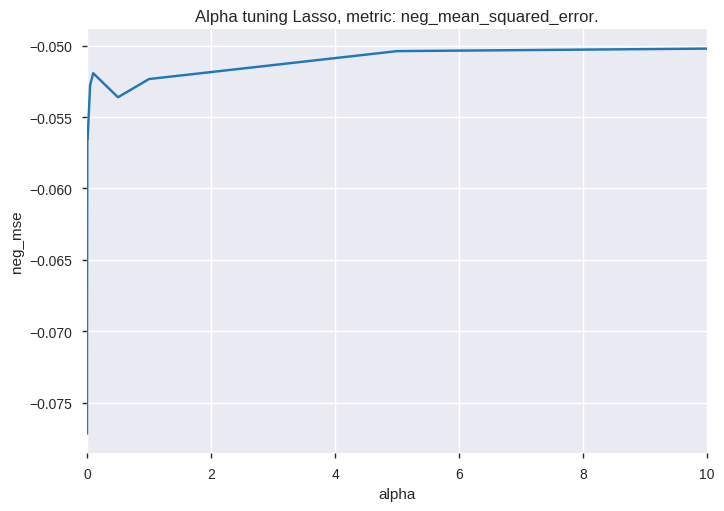

In [107]:
alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
cv_lasso = [score_cv(Lasso(alpha=alpha, random_state=random_state), "neg_mean_squared_error", X_BaseLine_train, y_log_train).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Alpha tuning Lasso, metric: neg_mean_squared_error.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

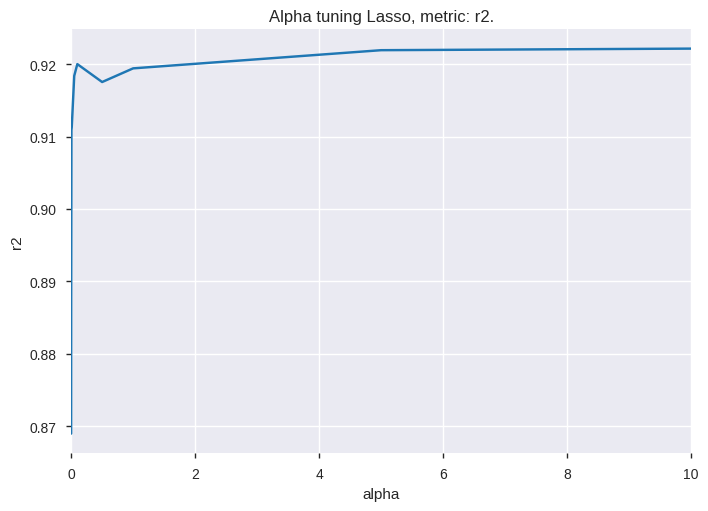

In [108]:
alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
cv_lasso = [score_cv(Lasso(alpha=alpha, random_state=random_state), "r2", X_BaseLine_train, y_log_train).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Alpha tuning Lasso, metric: r2.")
plt.xlabel("alpha")
plt.ylabel("r2")

In [129]:
%%time
linreg = Lasso( alpha=6, random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train, y_log_train)

Lasso(alpha=6, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.15343
neg_mean_squared_error -0.05027
neg_median_absolute_error -0.13050
r2 0.92211


CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 39.9 ms


In [130]:
linreg = Lasso( alpha=6, random_state=random_state)
linreg.fit(X_BaseLine_train, y_log_train)
linreg.coef_

array([ 0.        ,  0.00275679, -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ])

In [131]:
columns_wo_NAN

['PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'PT08.S3(NOx)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

### Adding features.

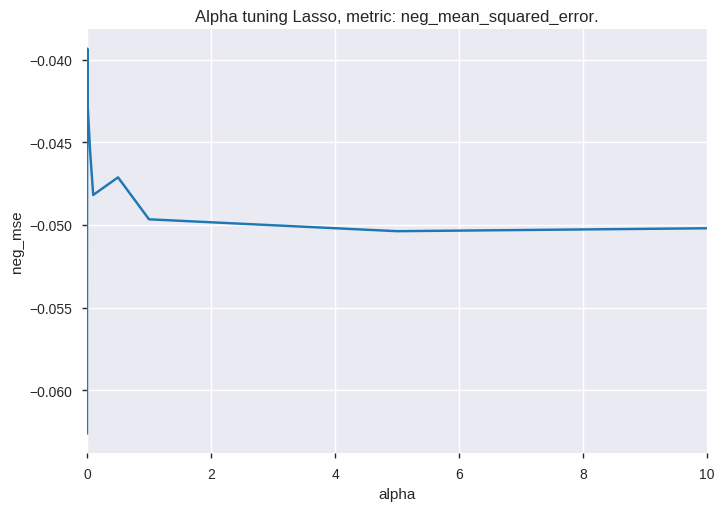

In [143]:
alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
cv_lasso = [score_cv(Lasso(alpha=alpha, random_state=random_state),
                     "neg_mean_squared_error",
                     X_time_train, y_log_train).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Alpha tuning Lasso, metric: neg_mean_squared_error.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

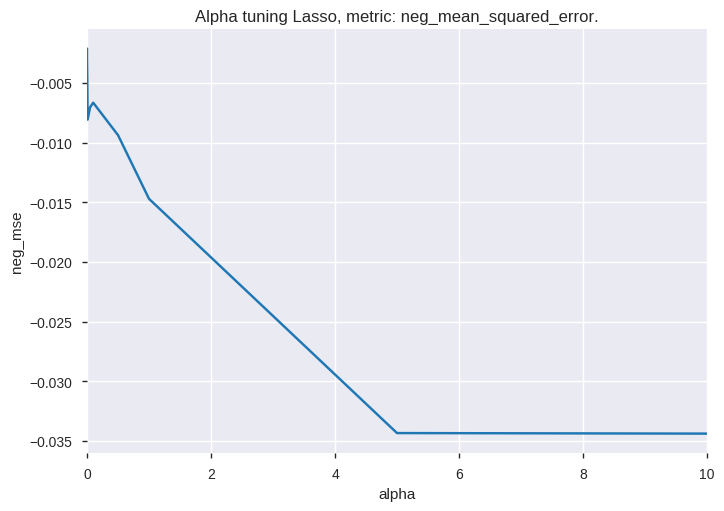

In [144]:
alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
cv_lasso = [score_cv(Lasso(alpha=alpha, random_state=random_state), "neg_mean_squared_error", X_all_train, y_log_train).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Alpha tuning Lasso, metric: neg_mean_squared_error.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

In [145]:
%%time
linreg = Lasso( alpha=0.00001, random_state=random_state)
    
model_fit_print_metr(linreg, X_all_train, y_log_train)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.02539
neg_mean_squared_error -0.00186
neg_median_absolute_error -0.01892
r2 0.99723


CPU times: user 24 s, sys: 120 ms, total: 24.1 s
Wall time: 5.76 s


In [159]:
%%time
linreg = Lasso( alpha=0.00001, random_state=random_state)
    
model_fit_print_metr(linreg, X_all_train_scl, y_log_train)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.02552
neg_mean_squared_error -0.00186
neg_median_absolute_error -0.01848
r2 0.99725


CPU times: user 24.7 s, sys: 80 ms, total: 24.7 s
Wall time: 6.17 s


In [263]:
linreg = Lasso( alpha=0.00001, random_state=random_state)
linreg.fit(X_all_train, y_log_train)
linreg.coef_

array([  2.66428670e-05,   8.33579172e-01,  -1.00555611e-03,
         6.19402815e-06,  -2.12655462e+00,  -1.84943165e-05,
        -7.41771770e-05,  -1.98484483e-04,   7.80876794e-03,
        -7.66114780e-03,   0.00000000e+00,   0.00000000e+00,
        -2.68355830e-03,  -5.04126503e-04,   1.61029457e-03,
         5.24146630e-04,   5.67740904e-03,   0.00000000e+00,
        -0.00000000e+00,   3.55306486e-05,   8.13648032e-04,
        -2.95534501e-03,  -1.18403745e-03,   1.00338511e-04,
        -2.83624264e-04,  -4.75192778e-03,  -8.28738910e-04,
        -5.15131318e-02,  -7.07548844e-04,  -0.00000000e+00,
        -0.00000000e+00,  -1.22655062e-06,   3.37909225e-10,
         1.37909899e-01,   2.95888697e+00,   1.25080876e-01,
        -5.25122992e-03,   5.43736541e+00,   6.29167240e-01,
        -2.41342963e-07,   7.20231929e-11,  -1.41135671e-02,
         7.05353414e-01,  -6.52976176e-08,   5.96366596e-11,
        -3.97435418e-02,   7.06794427e-01,  -2.08780904e-04,
         2.30810614e-06,

In [264]:
dict_coef = dict(zip(list(df), list(np.abs(linreg.coef_))))

coef_df = pd.DataFrame(list(dict_coef.items()), columns=['Feature', 'Coeff'])

coef_df["Coeff"] = coef_df["Coeff"].apply( lambda x: round(x, 3))

coef_df = coef_df[['Feature', 'Coeff']].sort_values(by='Coeff', ascending=False)

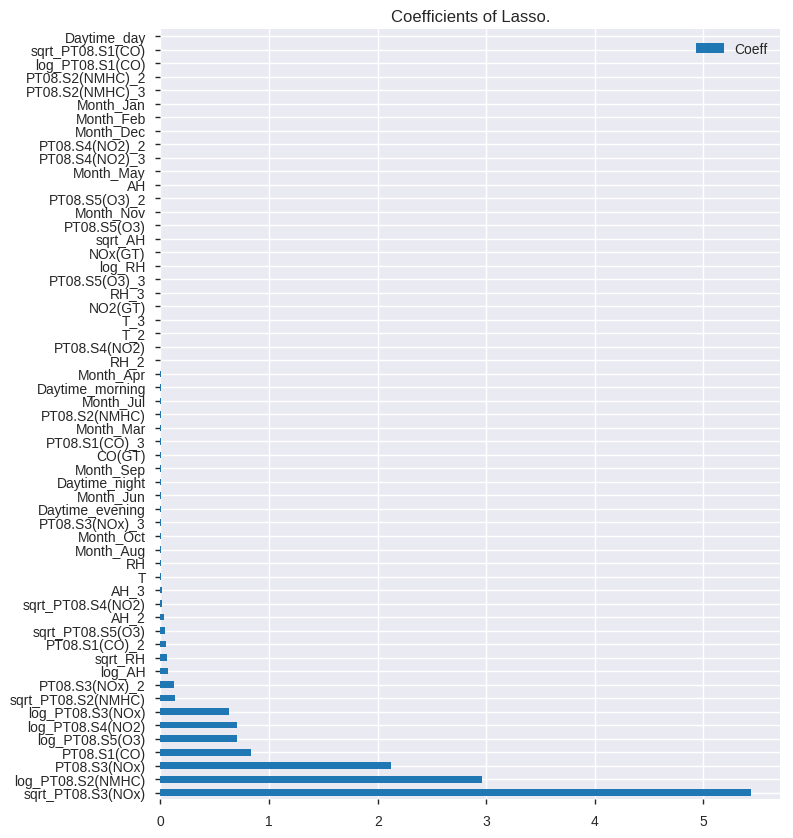

In [269]:
ax = coef_df .plot.barh(figsize=(8, 10))
plt.yticks(np.arange(0, 57), coef_df['Feature'].values)
plt.title("Coefficients of Lasso.")
plt.show()

## Ridge.

### Base.

In [155]:
%%time
linreg = Ridge(random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001) 

neg_mean_absolute_error -1.21970
neg_mean_squared_error -2.80403
neg_median_absolute_error -0.93026
r2 0.94775


CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 41.6 ms


### Scaled.

In [158]:
%%time
linreg = Ridge(random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train_scl, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001) 

neg_mean_absolute_error -1.26576
neg_mean_squared_error -2.94728
neg_median_absolute_error -0.97463
r2 0.94456


CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 43.1 ms


### Log target.

In [156]:
%%time
linreg = Ridge(random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train, y_log_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001) 

neg_mean_absolute_error -0.20100
neg_mean_squared_error -0.07095
neg_median_absolute_error -0.15239
r2 0.87994


CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 33.5 ms


### Scaled, log target.

In [157]:
%%time
linreg = Ridge(random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train_scl, y_log_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001) 

neg_mean_absolute_error -0.21166
neg_mean_squared_error -0.07771
neg_median_absolute_error -0.15812
r2 0.86816


CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 35.6 ms


### Parameter tuning for Ridge.

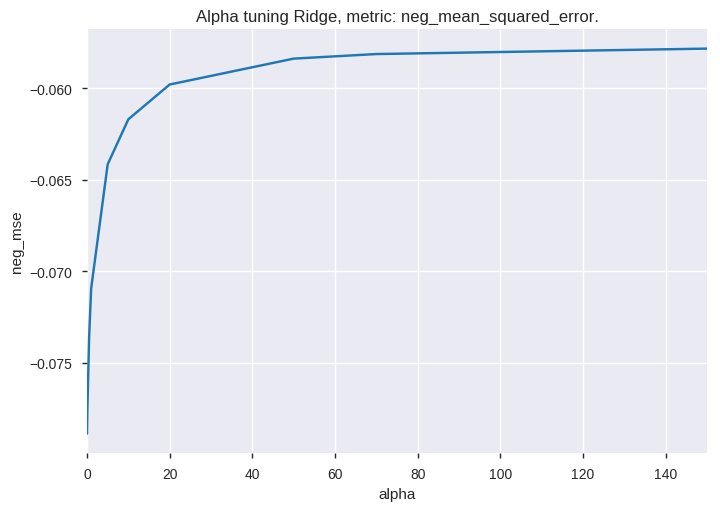

In [168]:
alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 70, 150]
cv_ridge = [score_cv( Ridge(alpha=alpha, random_state=random_state), "neg_mean_squared_error", X_BaseLine_train, y_log_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Alpha tuning Ridge, metric: neg_mean_squared_error.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

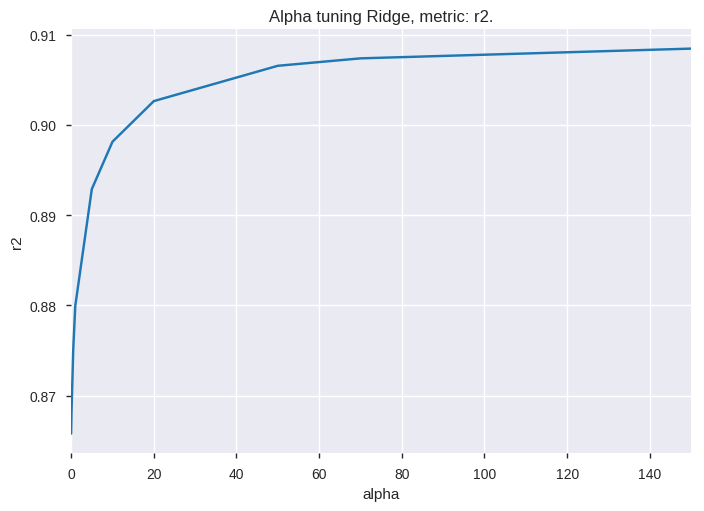

In [169]:
alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 70, 150]
cv_ridge = [score_cv( Ridge(alpha=alpha, random_state=random_state), "r2", X_BaseLine_train, y_log_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Alpha tuning Ridge, metric: r2.")
plt.xlabel("alpha")
plt.ylabel("r2")

In [170]:
%%time
linreg = Ridge( alpha=80, random_state=random_state)
    
model_fit_print_metr(linreg, X_BaseLine_train, y_log_train)

Ridge(alpha=80, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001) 

neg_mean_absolute_error -0.15429
neg_mean_squared_error -0.05806
neg_median_absolute_error -0.10005
r2 0.90765


CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 37.7 ms


### Adding features.

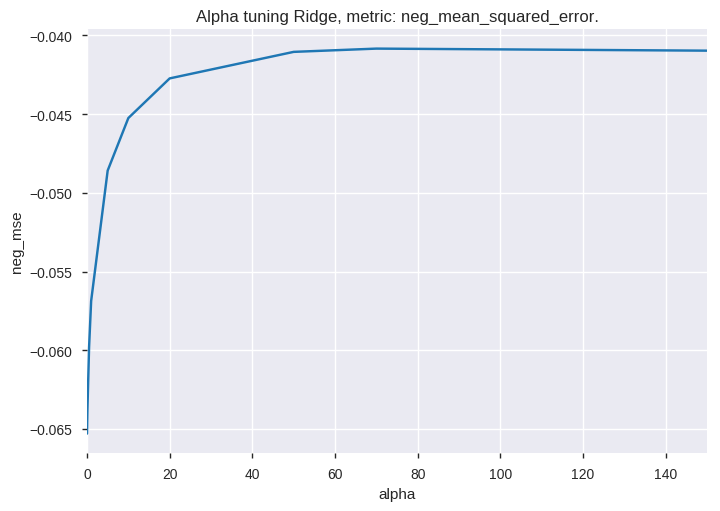

In [171]:
alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 70, 150]
cv_ridge = [score_cv( Ridge(alpha=alpha, random_state=random_state), "neg_mean_squared_error", X_time_train, y_log_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Alpha tuning Ridge, metric: neg_mean_squared_error.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

In [176]:
%%time
linreg = Ridge( alpha=80, random_state=random_state)
    
model_fit_print_metr(linreg, X_time_train, y_log_train)

Ridge(alpha=80, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001) 

neg_mean_absolute_error -0.12865
neg_mean_squared_error -0.04080
neg_median_absolute_error -0.09122
r2 0.93745


CPU times: user 1.05 s, sys: 16 ms, total: 1.07 s
Wall time: 263 ms


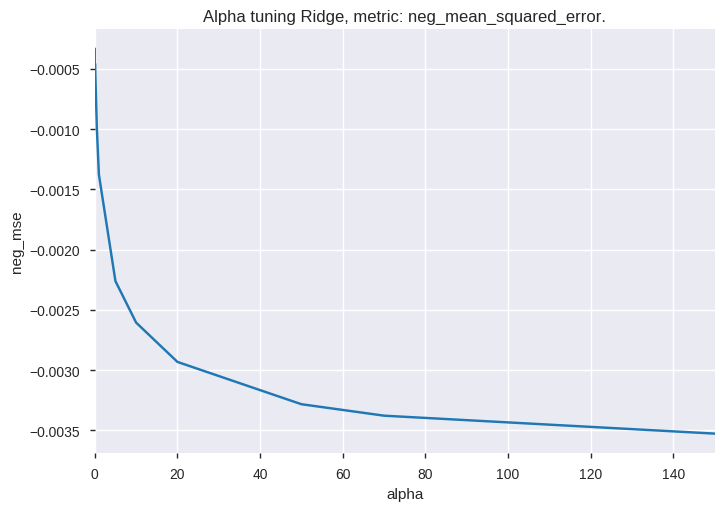

In [172]:
alphas = [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 70, 150]
cv_ridge = [score_cv( Ridge(alpha=alpha, random_state=random_state), "neg_mean_squared_error", X_all_train, y_log_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Alpha tuning Ridge, metric: neg_mean_squared_error.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

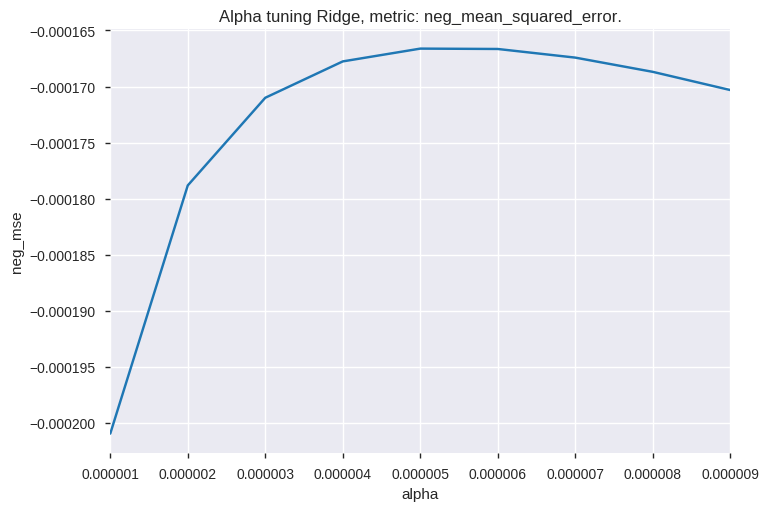

In [204]:
alphas = np.arange(0.000001, 0.00001, 0.000001)
cv_ridge = [score_cv( Ridge(alpha=alpha, random_state=random_state), "neg_mean_squared_error", X_all_train, y_log_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Alpha tuning Ridge, metric: neg_mean_squared_error.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

In [205]:
%%time
linreg = Ridge( alpha=0.000005, random_state=random_state)
    
model_fit_print_metr(linreg, X_all_train, y_log_train)

Ridge(alpha=5e-06, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001) 

neg_mean_absolute_error -0.00582
neg_mean_squared_error -0.00017
neg_median_absolute_error -0.00345
r2 0.99977


CPU times: user 964 ms, sys: 36 ms, total: 1e+03 ms
Wall time: 217 ms


## ElasticNet.

In [197]:
parameters = {'alpha':[ 1e-09, 1e-08, 1e-07],
              'l1_ratio':[  100, 200, 500]}

In [198]:
regr = ElasticNet(random_state=random_state)
clf = GridSearchCV(estimator=regr, param_grid=parameters, n_jobs=-1, cv=tscv, scoring="neg_mean_squared_error", verbose=1)

In [199]:
%%time

clf.fit(X_all_train, y_log_train)

print(clf.best_score_) 

print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed:   27.9s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   31.9s finished


-0.00179823183862
{'alpha': 1e-08, 'l1_ratio': 200}
CPU times: user 3.24 s, sys: 132 ms, total: 3.38 s
Wall time: 33.1 s


In [200]:
regr = ElasticNet(**clf.best_params_, random_state=random_state)

model_fit_print_metr(regr, X_all_train, y_log_train)

ElasticNet(alpha=1e-08, copy_X=True, fit_intercept=True, l1_ratio=200,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=17, selection='cyclic', tol=0.0001, warm_start=False) 

neg_mean_absolute_error -0.02525
neg_mean_squared_error -0.00180
neg_median_absolute_error -0.01885
r2 0.99729




## Predicting.

In [208]:
linreg = Ridge( alpha=0.000005, random_state=random_state)
linreg.fit(X_all_train, y_log_train)
y_pred = linreg.predict(X_all_test)

print_metrics(y_log_test, y_pred)

****************************************************************************************************

Regression metrics:

Mean absolute error 0.009
Mean squared error 0.0006
Median absolute error 0.0043
Explained variance score 0.9993
R2 score 0.9993 

****************************************************************************************************


Conclusion: Interesting task for beginners. There are different possibilities with data preprocessing to try and basic regressors to tune. One should pay attention to train test split and cross validation.